In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image

from gan import models, build_gan_trainer, kl_gan_loss_step
from utils.benchmark import train
from utils.display import display_images
from utils.checkpoints import load_checkpoint
from __datasets__ import CelebADataset

In [3]:
config_dc_gan = models.DCGanConfig(
    "../../pytorch/datasets/celeb-a",
    "DCGan-celeba",

    batch_size=16,
    norm=nn.BatchNorm2d,
    writer=False,
    lr=2e-4,
    p=0,

    inp_channels=128,
    hidden_channels=64,
    out_channels=3,
    upsample=4,
    n=0,
    blocks=(64, 128, 256, 512, 1024),
)

In [4]:
ds = CelebADataset(DIR=config_dc_gan.dataset_path, download=True, sub_sample=0.1,
                   image_transform=T.Compose([
                       T.Resize((64, 64)),
                       T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       lambda x: x.to(config_dc_gan.device),
                   ]))
len(ds), type(ds[0:1])

(20259, dict)

In [5]:
generator, discriminator = models.build_DCGan(config_dc_gan)
optimizerG = optim.Adam(generator.parameters(), lr=config_dc_gan.lr, betas=config_dc_gan.betas)
optimizerD = optim.Adam(discriminator.parameters(), lr=config_dc_gan.lr, betas=config_dc_gan.betas)

In [6]:
if input("Load Model[y|n]?> ").lower() == "y":
    others = load_checkpoint(
        input("path?> "),
        {"generator": generator, "discriminator": discriminator},
        {"generator": optimizerG, "discriminator": optimizerD},
    )
    step_offset = others["step"]
else:
    step_offset = 0
step_offset

0

In [7]:
def data_extractor(DATA):
    real = DATA["image"]
    noise = torch.randn((len(DATA["image"]), config_dc_gan.inp_channels, 1, 1), device=config_dc_gan.device)
    return real, noise

fixed_inp = torch.randn((9 * 9, config_dc_gan.inp_channels, 1, 1), device=config_dc_gan.device)
trainer = build_gan_trainer(
    generator, discriminator,
    optimizerG, optimizerD,
    kl_gan_loss_step, data_extractor,
    save_path=None, save_period=500,
    writer=config_dc_gan.writer, writer_period=250, fixed_inp=fixed_inp,
    perceptual_loss=False,
    device=config_dc_gan.device,
)

In [8]:
print(generator, end="\n\n")
print(discriminator, end="\n\n")
print((fake := generator(fixed_inp)).cpu().shape, discriminator(fake).shape)

DCGenerator(
  (head): ConvBlock(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
  (blocks): Sequential(
    (0): ConvBlock(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvBlock(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvBlock(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): ConvBlock(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(

In [9]:
generator = generator.train()
discriminator = discriminator.train()
step_offset = train(
    trainer, ds,
    ne=1, bs=config_dc_gan.batch_size,
    step_offset=step_offset,
)
step_offset

Epoch: 0/1 | Batch 0/1267|          |  0% [00:00<?, ?it/s ]

1267

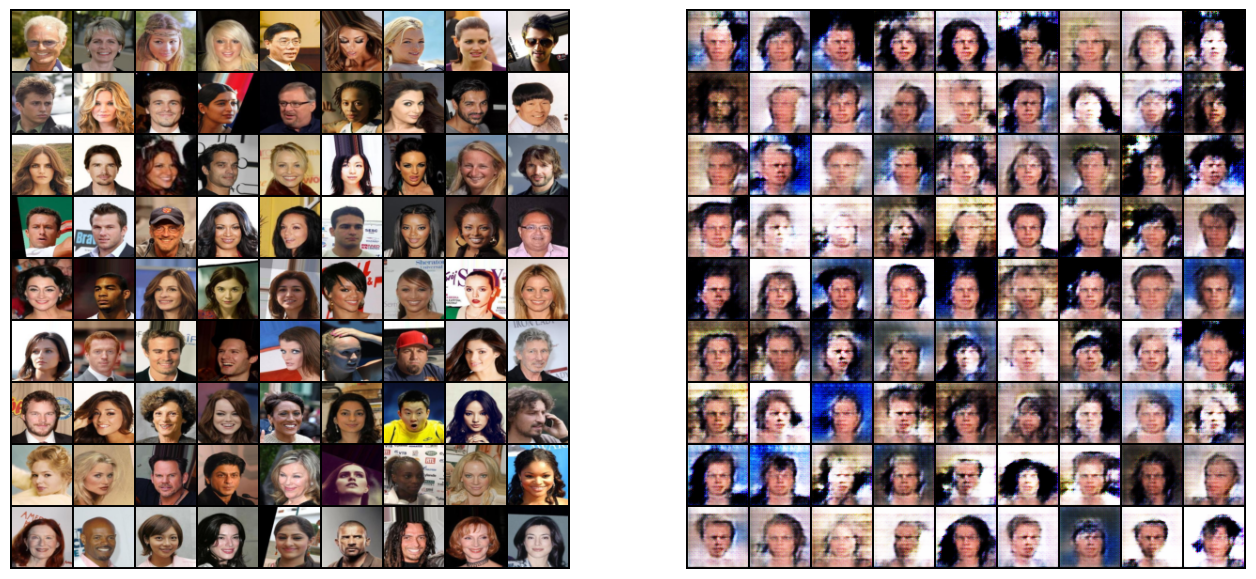

CPU times: user 1.39 s, sys: 1.29 s, total: 2.68 s
Wall time: 1.39 s


In [10]:
%%time

generator = generator.eval()
discriminator = discriminator.eval()
with torch.inference_mode():
    real = ds[torch.randperm(len(ds))[:9 * 9].tolist()]["image"]
    noise = torch.randn((9 * 9, config_dc_gan.inp_channels, 1, 1), device=config_dc_gan.device)
    fake = generator(noise)
    grid_real = make_grid(real, nrow=9, normalize=True)
    grid_fake = make_grid(fake, nrow=9, normalize=True)
display_images(torch.stack([grid_real, grid_fake]).cpu().permute(0, 2, 3, 1))

In [ ]:
save_image(grid_fake, "grid_fake.png")